# Project: Real-time Weapon Detection 

Name: Pratik Naik <br>
UID: U01980342 <br>
Email Id: pn17756n@pace.edu <br>
Course: Introduction to Deep Learning (CS672) <br>
CRN: 23203 <br>
Term: Spring 2025

This notebook aims to build a real-time object detection model specifically to identify weapons (e.g., guns, knives) using a custom deep learning model and webcam feed — without using pre-trained models like YOLO or SSD.

## Install Required Libraries

In [7]:
!pip install tensorflow opencv-python matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 37.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.16.2 requires tensorflow==2.16.2; platform_system == "Darwin" and platform_machine == "arm64", but you have tensorflow 2.17.0 which is incompatible.


## Importing Libraries

In [2]:
import os # Ensure the script is running in the correct directory
import cv2 # OpenCV for image processing
import numpy as np # Numerical operations
import tensorflow as tf # Deep learning model framework
import matplotlib.pyplot as plt # Plotting library
import random # Random number generation

## Set Data filepaths

In [5]:
images_path = '/Users/pratiknaik/University/Spring 2025/CS672 Deep Learning/Project/dataset/WEAPON_DETECTION_FINAL/train/images' #  Path to the images
labels_path = '/Users/pratiknaik/University/Spring 2025/CS672 Deep Learning/Project/dataset/WEAPON_DETECTION_FINAL/train/labels' # Path to the labels
labels_list = ['Grenade', 'Gun', 'Knife', 'Pistol'] # List of all images and labels

## Load YOLO Data (Only One Object per Image)

In [8]:
# Function to load YOLO data

# This function loads images and their corresponding bounding boxes and classes from the specified directories.
def load_yolo_data(images_path, labels_path, img_size=416):
    images, boxes, classes = [], [], [] # Initialize empty lists to store images, bounding boxes, and classes.
    label_files = os.listdir(labels_path) # List all label files in the labels directory

    for label_file in label_files: # Iterate through each label file
        img_file = label_file.replace('.txt', '.jpg')   # Replace the .txt extension with .jpg to get the corresponding image file name
        img_full_path = os.path.join(images_path, img_file) # Construct the full path to the image file
        label_full_path = os.path.join(labels_path, label_file) # Construct the full path to the label file

        if not os.path.exists(img_full_path): # Check if the image file exists
            continue

        img = cv2.imread(img_full_path) # Read the image using OpenCV
        img = cv2.resize(img, (img_size, img_size)) # It resizes the images to a specified size and normalizes the pixel values.
        img = img / 255.0 # Normalize pixel values to the range [0, 1]

        with open(label_full_path, 'r') as f: # Open the label file for reading
            lines = f.readlines() # Read all lines from the label file

        if len(lines) == 0: # Check if the label file is empty
            continue 

        data = lines[0].strip().split() # Split the first line into individual components
        cls_id, x, y, w, h = map(float, data) # Convert the components to float values

        images.append(img) # Append the image to the images list
        boxes.append([x, y, w, h]) # The bounding boxes are represented as [x, y, width, height], and the classes are represented as integers.
        classes.append(int(cls_id)) # Append the class ID to the classes list

    return np.array(images), np.array(boxes), np.array(classes) # The function returns three numpy arrays: images, boxes, and classes.



## Load and Prepare Data

In [11]:
X_train, y_bbox, y_class = load_yolo_data(images_path, labels_path) # Load the YOLO data using the function defined above

print(f"Loaded {len(X_train)} images") # Print the number of loaded images


Loaded 4541 images


## Display Sample Images

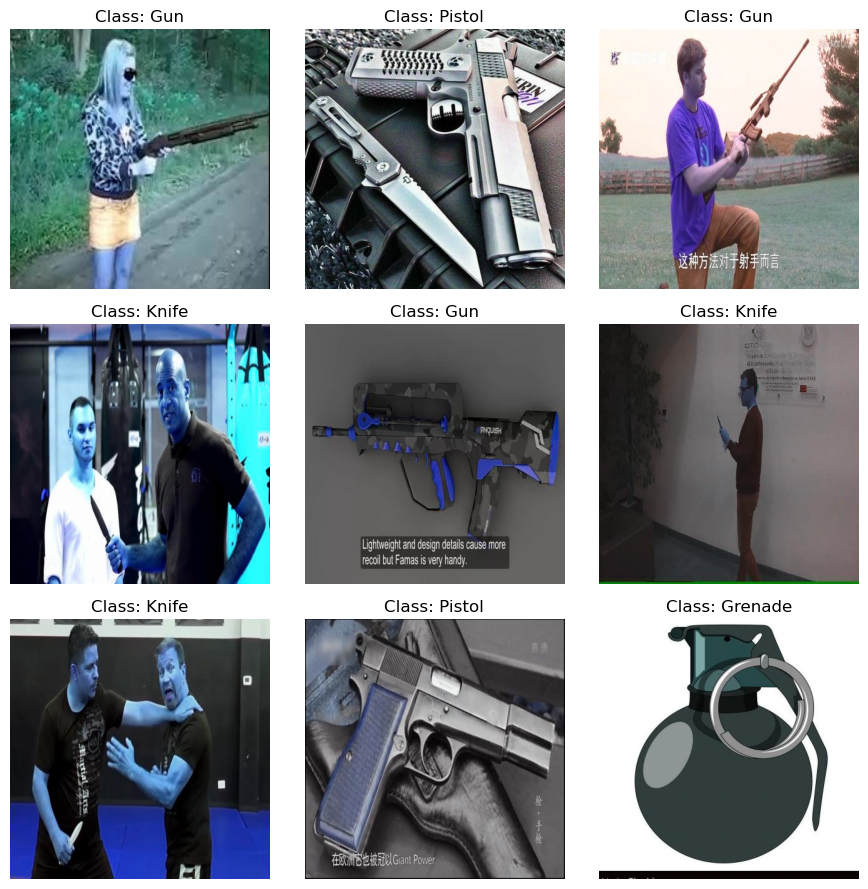

In [14]:
plt.rcParams['figure.figsize'] = (9, 9) # Set the figure size for the plots
for i in range(9): # Display 9 random images from the training set
    plt.subplot(3, 3, i + 1) # Create a subplot for each image
    num = random.randint(0, len(X_train) - 1) # Randomly select an image index
    plt.imshow(X_train[num]) # Display the image
    plt.title(f"Class: {labels_list[y_class[num]]}") # Set the title to the class name
    plt.axis('off') # Turn off the axis
plt.tight_layout() # Adjust the layout to prevent overlap
plt.show() # Show the plot



## Build a Simple CNN Model

In [17]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout # Import necessary layers from Keras
from tensorflow.keras.models import Model # Import the Model class from Keras

inputs = Input(shape=(416, 416, 3)) # Define the input shape for the model 
x = Conv2D(16, (3,3), activation='relu')(inputs) # Add a convolutional layer with 16 filters and a kernel size of 3x3
x = MaxPooling2D((2,2))(x) # Add a max pooling layer with a pool size of 2x2
x = Conv2D(32, (3,3), activation='relu')(x) # Add another convolutional layer with 32 filters
x = MaxPooling2D((2,2))(x) # Add another max pooling layer
x = Conv2D(64, (3,3), activation='relu')(x) # Add another convolutional layer with 64 filters
x = MaxPooling2D((2,2))(x) # Add another max pooling layer
x = Conv2D(128, (3,3), activation='relu')(x) # Add another convolutional layer with 128 filters
x = MaxPooling2D((2,2))(x) # Add another max pooling layer
x = Flatten()(x) # Flatten the output from the previous layer to create a 1D vector
x = Dense(256, activation='relu')(x) # Add a fully connected layer with 256 units
x = Dropout(0.3)(x) # Add a dropout layer with a dropout rate of 0.3 to prevent overfitting

bbox_output = Dense(4, activation='sigmoid', name='bbox')(x) # Add a fully connected layer for bounding box output with 4 units (x, y, width, height)
class_output = Dense(4, activation='softmax', name='class')(x) # Add a fully connected layer for class output with 4 units (one for each class) and softmax activation

model = Model(inputs, [bbox_output, class_output]) # Create the model by specifying the inputs and outputs
model.compile(optimizer='adam',
              loss={'bbox': 'mse', 'class': 'sparse_categorical_crossentropy'},
              metrics={'class': 'accuracy'}) # Compile the model with Adam optimizer, mean squared error loss for bounding boxes, and sparse categorical crossentropy for class output
model.summary() # Print the model summary to see the architecture and number of parameters


2025-05-10 10:50:31.057423: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-10 10:50:31.057766: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-10 10:50:31.057976: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-10 10:50:31.058177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-10 10:50:31.058203: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 414, 414,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 207, 207,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 205, 205,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 102, 102,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 100,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 50,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 24, 24,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 73728)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 18,874,624 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Dense)        │ (None, 4)         │      1,028 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class (Dense)       │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,974,120 (72.38 MB)

 Trainable params: 18,974,120 (72.38 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping callback to prevent overfitting

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Create an EarlyStopping callback to monitor validation loss and stop training if it doesn't improve for 5 epochs

history = model.fit( 
    X_train,
    {'bbox': y_bbox, 'class': y_class},
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
) # Train the model using the training data, with a validation split of 20% and early stopping to prevent overfitting


model.save('weapon_detection_model.keras')  # Save the trained model to a file


Epoch 1/50


2025-05-10 10:52:36.346583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-10 10:52:36.355339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


227/227 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - bbox_loss: 0.0531 - class_accuracy: 0.2619 - class_loss: 1.3862 - loss: 1.4393 - val_bbox_loss: 0.0520 - val_class_accuracy: 0.2816 - val_class_loss: 1.3859 - val_loss: 1.4379
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - bbox_loss: 0.0493 - class_accuracy: 0.2590 - class_loss: 1.3856 - loss: 1.4349 - val_bbox_loss: 0.0512 - val_class_accuracy: 0.2739 - val_class_loss: 1.3868 - val_loss: 1.4379
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - bbox_loss: 0.0489 - class_accuracy: 0.2872 - class_loss: 1.3843 - loss: 1.4332 - val_bbox_loss: 0.0510 - val_class_accuracy: 0.2728 - val_class_loss: 1.3872 - val_loss: 1.4381
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - bbox_loss: 0.0490 - class_accuracy: 0.2536 - class_loss: 1.3858 - loss: 1.4348 - val_bbox_loss: 0.0510 - val_class_accuracy: 0.2728 - val_class_loss: 1.3877 - val_loss: 1.4386
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - bbox_loss: 0.0478 - cl

## Plot Training Performance

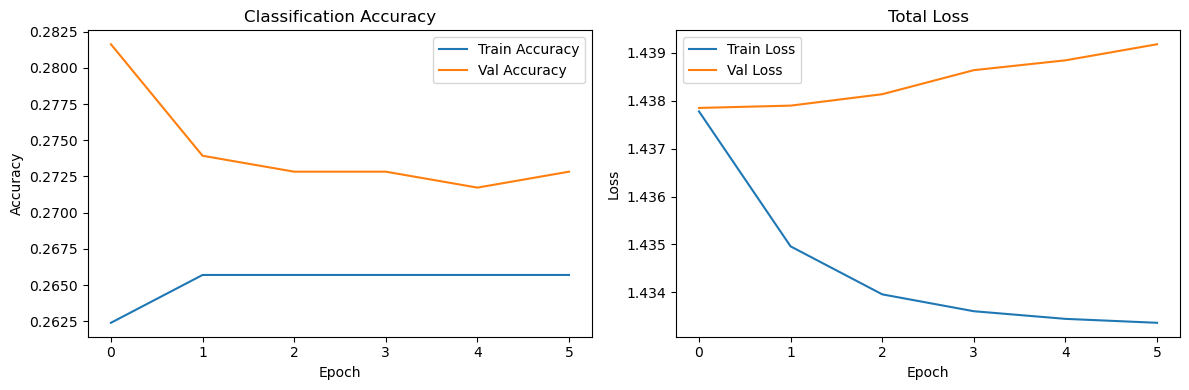

In [22]:
plt.figure(figsize=(12, 4)) # Create a figure with a specified size for the plots

# Classification Accuracy
plt.subplot(1, 2, 1) 
plt.plot(history.history['class_accuracy'], label='Train Accuracy') 
plt.plot(history.history['val_class_accuracy'], label='Val Accuracy') 
plt.title('Classification Accuracy') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Total Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Real-Time Webcam Detection with Alert

In [25]:
model = tf.keras.models.load_model('weapon_detection_model.keras') # Load the trained model from the file
cap = cv2.VideoCapture(0) # Open the webcam for real-time detection

while True: 
    ret, frame = cap.read() # Read a frame from the webcam
    if not ret: # Check if the frame was read successfully
        break 

    resized_frame = cv2.resize(frame, (416, 416)) / 255.0 # Resize the frame to the input size of the model and normalize pixel values
    input_img = np.expand_dims(resized_frame, axis=0) # Add a batch dimension to the input image

    bbox_pred, class_pred = model.predict(input_img, verbose=0) # Make predictions using the model
    class_idx = np.argmax(class_pred[0]) # Get the index of the class with the highest probability
    confidence = class_pred[0][class_idx] # Get the confidence score for the predicted class

    # Print for debugging
    print(f"Prediction: class={class_idx}, label={labels_list[class_idx]}, conf={confidence:.2f}") 
    print(f"Predicted bbox: {bbox_pred[0]}") 

    if confidence > 0.4:  # Reduced threshold for testing
        label = labels_list[class_idx] 
        x, y, w, h = bbox_pred[0] 

        # Convert normalized bbox to pixel values
        x1 = int((x - w/2) * frame.shape[1]) 
        y1 = int((y - h/2) * frame.shape[0])
        x2 = int((x + w/2) * frame.shape[1])
        y2 = int((y + h/2) * frame.shape[0]) 

        # Draw bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2) 
        cv2.putText(frame, f"{label}: {confidence:.2f}", (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2) 

        print(f"🔴 ALERT: {label} detected with confidence {confidence:.2f}")
    else:
        print("✅ No confident detection.")

    cv2.imshow('Real-Time Weapon Detection', frame) # Display the frame with bounding box and label
    if cv2.waitKey(1) & 0xFF == ord('q'):   # Exit the loop if 'q' is pressed
        break   

cap.release() # Release the webcam
cv2.destroyAllWindows() # Close all OpenCV windows


2025-05-10 11:54:44.939 python[36896:34628311] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2025-05-10 11:54:47.106144: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Prediction: class=2, label=Knife, conf=0.26
Predicted bbox: [0.48110378 0.52374387 0.45670938 0.470499  ]
✅ No confident detection.
Prediction: class=2, label=Knife, conf=0.26
Predicted bbox: [0.482458   0.523861   0.45642686 0.46881667]
✅ No confident detection.
Prediction: class=2, label=Knife, conf=0.26
Predicted bbox: [0.48251882 0.5238848  0.45636985 0.46876267]
✅ No confident detection.
Prediction: class=2, label=Knife, conf=0.26
Predicted bbox: [0.48255506 0.5238633  0.45630962 0.46871063]
✅ No confident detection.
Prediction: class=2, label=Knife, conf=0.26
Predicted bbox: [0.48256296 0.52384937 0.4563612  0.4687208 ]
✅ No confident detection.
Prediction: class=2, label=Knife, conf=0.26
Predicted bbox: [0.4826745  0.5239154  0.45637515 0.4687111 ]
✅ No confident detection.
Prediction: class=2, label=Knife, conf=0.26
Predicted bbox: [0.48267812 0.5239319  0.4563689  0.46877652]
✅ No confident detection.
Prediction: class=2, label=Knife, conf=0.26
Predicted bbox: [0.4826738  0.52

KeyboardInterrupt: 